## Import Dependencies


In [2]:
import os
import json
import numpy as np
import zipfile
import random
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split


## Download Dataset from Kaggle
The following code downloads the German Traffic Sign Detection (GTSDB) dataset to a local directory.

In [3]:
!export KAGGLE_API_TOKEN=

KAGGLE_USERNAME = "gonzaloaguero"
KAGGLE_API_TOKEN = "6e8f580918f711f0338d1ac47bcbf5af"

In [4]:
# 1. Crear estructura de carpetas
kaggle_path = os.path.expanduser("~/.kaggle")
kaggle_config_path = os.path.join(kaggle_path, 'kaggle.json')
os.makedirs(kaggle_path, exist_ok=True)

kaggle_json = {"username": KAGGLE_USERNAME, "key": KAGGLE_API_TOKEN}
with open(kaggle_config_path, 'w') as f:
    json.dump(kaggle_json, f)

# 3. Permisos (chmod 600)
os.chmod(kaggle_config_path, 0o600)

# 4. Set Kaggle API credentials (ensure kaggle.json is in ~/.kaggle or provide the path)
os.environ['KAGGLE_CONFIG_DIR'] = str(kaggle_path)

# 5. Create the download directory if it doesn't exist
download_dir = "./gtsdb_data"
os.makedirs(download_dir, exist_ok=True)

# 6. Download the dataset using Kaggle API
!kaggle datasets download -d icebearogo/german-traffic-sign-detection-gtsdb-dataset -p "$download_dir"

Dataset URL: https://www.kaggle.com/datasets/icebearogo/german-traffic-sign-detection-gtsdb-dataset
License(s): Attribution-NonCommercial 4.0 International (CC BY-NC 4.0)
 56% 131M/234M [00:00<00:00, 1.37GB/s]
100% 234M/234M [00:00<00:00, 727MB/s] 


In [5]:
!ls gtsdb_data/

german-traffic-sign-detection-gtsdb-dataset.zip


In [6]:
# Extract the zip file
ZIP_PATH = os.path.join(download_dir, "german-traffic-sign-detection-gtsdb-dataset.zip")
extract_dir = os.path.join(download_dir, "GTSDB_Train_and_Test")
with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall(download_dir)
    
!ls gtsdb_data/

german-traffic-sign-detection-gtsdb-dataset.zip  GTSDB_Train_and_Test


In [7]:
!ls gtsdb_data/GTSDB_Train_and_Test

'ReadME__(yes actually take a look).txt'   Test   Train


## Load and Analyze Dataset

In [8]:
# Define la ruta base donde se encuentran las carpetas 'images' y 'labels'
BASE_PATH = "/content/gtsdb_data/GTSDB_Train_and_Test"

# Define las rutas específicas para imágenes y etiquetas de entrenamiento/prueba
SETS = {
    'train': {'images': os.path.join(BASE_PATH, 'Train', 'images'),
              'labels': os.path.join(BASE_PATH, 'Train', 'labels')},
    'test':  {'images': os.path.join(BASE_PATH, 'Test', 'images'),
              'labels': os.path.join(BASE_PATH, 'Test', 'labels')}
}

In [9]:
def load_yolo_annotations(label_dir, image_dir, dataset_type):
    """
    Carga todas las anotaciones de las etiquetas YOLO en un DataFrame.
    """
    data = []
    
    # Listar todos los archivos de etiquetas (.txt)
    label_files = [f for f in os.listdir(label_dir) if f.endswith('.txt')]
    
    for label_file in label_files:
        # Extraer el nombre base del archivo (ej. '00603')
        base_name = os.path.splitext(label_file)[0]
        
        # Construir la ruta completa de la imagen y la etiqueta
        image_path = os.path.join(image_dir, base_name + '.jpg')
        label_path = os.path.join(label_dir, label_file)

        # Verificar que la imagen exista
        if not os.path.exists(image_path):
            print(f"Advertencia: No se encontró la imagen para {base_name}. Saltando.")
            continue
            
        # Leer el archivo de etiqueta
        try:
            with open(label_path, 'r') as f:
                lines = f.readlines()
                
            # Procesar cada línea (cada señal detectada)
            for line in lines:
                parts = line.strip().split()
                if len(parts) == 5:
                    class_id = int(parts[0])
                    # Las coordenadas están normalizadas (float)
                    x_center, y_center, width, height = map(float, parts[1:])
                    
                    # Añadir la entrada al listado de datos
                    data.append({
                        'dataset_type': dataset_type, # 'train' o 'test'
                        'image_id': base_name,
                        'image_path': image_path,
                        'class_id': class_id,
                        'x_center_norm': x_center,
                        'y_center_norm': y_center,
                        'width_norm': width,
                        'height_norm': height
                    })
                
        except Exception as e:
            print(f"Error al procesar el archivo de etiqueta {label_file}: {e}")

    return pd.DataFrame(data)


# Cargar datos de entrenamiento
df_train = load_yolo_annotations(
    SETS['train']['labels'], 
    SETS['train']['images'], 
    'train'
)

# Cargar datos de prueba
df_test = load_yolo_annotations(
    SETS['test']['labels'], 
    SETS['test']['images'], 
    'test'
)

# Concatenar ambos DataFrames
df_gtsdb = pd.concat([df_train, df_test], ignore_index=True)

# Mostrar la información básica del DataFrame consolidado
print(f"Total de anotaciones cargadas: {len(df_gtsdb)}")
print("\nPrimeras 5 filas del DataFrame consolidado:")
print(df_gtsdb.head())
print("\nInformación de las columnas:")
df_gtsdb.info()

Total de anotaciones cargadas: 867

Primeras 5 filas del DataFrame consolidado:
  dataset_type image_id                                         image_path  \
0        train    00353  /content/gtsdb_data/GTSDB_Train_and_Test/Train...   
1        train    00382  /content/gtsdb_data/GTSDB_Train_and_Test/Train...   
2        train    00023  /content/gtsdb_data/GTSDB_Train_and_Test/Train...   
3        train    00408  /content/gtsdb_data/GTSDB_Train_and_Test/Train...   
4        train    00209  /content/gtsdb_data/GTSDB_Train_and_Test/Train...   

   class_id  x_center_norm  y_center_norm  width_norm  height_norm  
0        10       0.343015       0.712500    0.015441      0.02750  
1        10       0.904779       0.690625    0.028676      0.04875  
2        23       0.717279       0.579375    0.044853      0.07125  
3        18       0.861029       0.642500    0.057353      0.08750  
4        13       0.838603       0.310625    0.063971      0.09625  

Información de las columnas:
<class 

In [10]:
# Check its normalized values
df_gtsdb.describe()

,class_id,x_center_norm,y_center_norm,width_norm,height_norm
count,867.000000,867.000000,867.000000,867.000000,867.000000
mean,16.320646,0.577647,0.563727,0.032798,0.054824
std,13.377572,0.225873,0.110270,0.016196,0.026490
min,0.000000,0.034559,0.110000,0.011765,0.020000
25%,5.000000,0.399817,0.500625,0.021324,0.036250
50%,12.000000,0.621691,0.565000,0.027941,0.047500
75%,29.000000,0.740074,0.651563,0.040441,0.067500
max,100.000000,0.972794,0.865625,0.093382,0.160000


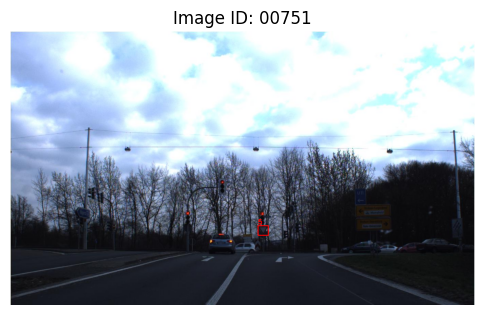

In [11]:
# Show a single random image with its bounding boxes
img_id = np.random.choice(df_gtsdb['image_id'].unique())
img_annots = df_gtsdb[df_gtsdb['image_id'] == img_id]
img_path = img_annots.iloc[0]['image_path']
img = cv2.imread(img_path)
if img is None:
    print(f"No se pudo cargar la imagen: {img_path}")
else:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    for _, row in img_annots.iterrows():
        x_center = row['x_center_norm'] * w
        y_center = row['y_center_norm'] * h
        box_w = row['width_norm'] * w
        box_h = row['height_norm'] * h

        x1 = int(x_center - box_w / 2)
        y1 = int(y_center - box_h / 2)
        x2 = int(x_center + box_w / 2)
        y2 = int(y_center + box_h / 2)

        cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
        cv2.putText(img, str(row['class_id']), (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Image ID: {img_id}")
    plt.axis('off')
    plt.show()


In [12]:
# --- Mapeo de IDs a Descripciones Legibles ---
class_map = {
    0: 'Límite 20 km/h', 1: 'Límite 30 km/h', 2: 'Límite 50 km/h', 
    3: 'Límite 60 km/h', 4: 'Límite 70 km/h', 5: 'Límite 80 km/h', 
    6: 'Fin Límite 80 km/h', 7: 'Límite 100 km/h', 8: 'Límite 120 km/h', 
    9: 'Prohibido Adelantar', 10: 'Proh. Adelantar (Camiones)', 
    11: 'Intersección con Prioridad', 12: 'Prioridad en Carretera', 
    13: 'Ceda el Paso', 14: 'Stop', 15: 'Prohibido Entrada Vehículos', 
    16: 'Proh. Entrada Vehículos > 3.5t', 17: 'Prohibido Entrada', 
    18: 'Advertencia General', 19: 'Curva Peligrosa Izquierda', 
    20: 'Curva Peligrosa Derecha', 21: 'Curva Doble', 22: 'Carretera Irregular', 
    23: 'Carretera Resbaladiza', 24: 'Estrechamiento Derecha', 25: 'Obras', 
    26: 'Semáforo', 27: 'Paso de Peatones', 28: 'Cruce de Niños', 
    29: 'Cruce de Bicicletas', 30: 'Hielo / Nieve', 31: 'Animales Salvajes', 
    32: 'Fin de Restricciones', 33: 'Girar Derecha Obligatorio', 
    34: 'Girar Izquierda Obligatorio', 35: 'Seguir Recto Obligatorio', 
    36: 'Recto o Derecha', 37: 'Recto o Izquierda', 38: 'Pasar por Derecha', 
    39: 'Pasar por Izquierda', 40: 'Rotonda Obligatoria', 
    41: 'Fin de No Adelantar', 42: 'Fin de No Adelantar (Camiones)',
    100: 'Señal Genérica / Otra' 
}

# --- Mapeo de IDs a Tipos de Señal (Según la documentación) ---
# Se utiliza un diccionario que mapea ID -> TIPO para facilitar el proceso.

# Definición de Categorías por ID
PROHIBITORY_IDS = [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 15, 16, 17] 
DANGER_IDS = [11, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31] 
MANDATORY_IDS = [33, 34, 35, 36, 37, 38, 39, 40] 
# El resto son: Priority (12, 13, 14), Regulatory/End of Restrictions (6, 32, 41, 42) y el 100

# Creación del Diccionario de Mapeo de Tipos
type_map = {}
for i in range(43): # Recorre todas las IDs de 0 a 42
    if i in PROHIBITORY_IDS:
        type_map[i] = 'Prohibición'
    elif i in DANGER_IDS:
        type_map[i] = 'Peligro'
    elif i in MANDATORY_IDS:
        type_map[i] = 'Obligatoria'
    elif i in [12, 13, 14]:
        type_map[i] = 'Prioridad / Stop'
    elif i in [6, 32, 41, 42]:
        type_map[i] = 'Fin de Restricción'
    else:
        type_map[i] = 'Otras' 

# Agregar la clase 100
type_map[100] = 'General/Sin Clasificar'


# --- Aplicar Mapeos al DataFrame ---

# Aplicar el mapeo de nombres
df_gtsdb['class_name'] = df_gtsdb['class_id'].map(class_map)

# Aplicar el mapeo de tipos de señal
df_gtsdb['type_of_sign'] = df_gtsdb['class_id'].map(type_map)

# Verificar el resultado
print("\nDataFrame con nombres y tipos de clases:")
print(df_gtsdb[['class_id', 'class_name', 'type_of_sign', 'dataset_type']].head(10))


DataFrame con nombres y tipos de clases:
   class_id                  class_name      type_of_sign dataset_type
0        10  Proh. Adelantar (Camiones)       Prohibición        train
1        10  Proh. Adelantar (Camiones)       Prohibición        train
2        23       Carretera Resbaladiza           Peligro        train
3        18         Advertencia General           Peligro        train
4        13                Ceda el Paso  Prioridad / Stop        train
5         7             Límite 100 km/h       Prohibición        train
6         3              Límite 60 km/h       Prohibición        train
7         5              Límite 80 km/h       Prohibición        train
8        38           Pasar por Derecha       Obligatoria        train
9        12      Prioridad en Carretera  Prioridad / Stop        train


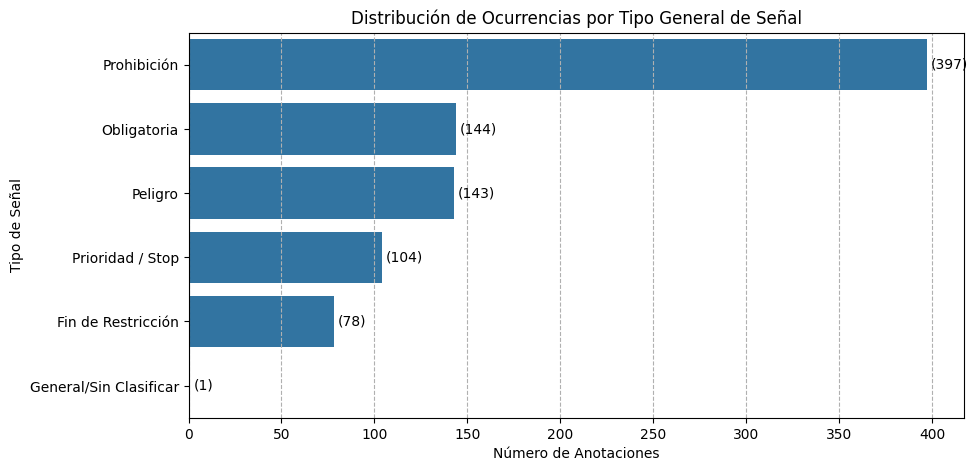

In [13]:
plt.figure(figsize=(10, 5))
# Contar el número de ocurrencias para cada tipo de señal
order = df_gtsdb['type_of_sign'].value_counts().index
ax = sns.countplot(y='type_of_sign', data=df_gtsdb, order=order)

# Agregar el número de muestras sobre cada barra
for p in ax.patches:
    width = int(p.get_width())
    y = p.get_y() + p.get_height() / 2
    ax.text(width + 2, y, f'({width})', va='center')

plt.title('Distribución de Ocurrencias por Tipo General de Señal')
plt.xlabel('Número de Anotaciones')
plt.ylabel('Tipo de Señal')
plt.grid(axis='x', linestyle='--')
plt.show()

The type "General/Sin Clasificar" has only one example. So it will be removed so it does not cause problems with the training.

In [14]:
# Remove the General/Sin Clasificar type
df_gtsdb = df_gtsdb[df_gtsdb['class_id'] != 100].reset_index(drop=True)


Distribución de Clases
class_id
12    64
1     63
38    61
2     60
5     53
4     46
10    43
34    42
32    33
13    29
7     28
18    27
3     27
9     26
11    20
6     19
8     18
23    17
35    15
41    13
42    13
26    12
16    12
25    12
14    11
17    10
33     9
30     9
19     9
21     8
15     8
29     7
28     7
40     7
27     5
37     4
39     4
22     4
0      3
20     3
36     2
24     2
31     1
Name: count, dtype: int64


<Axes: xlabel='class_id'>

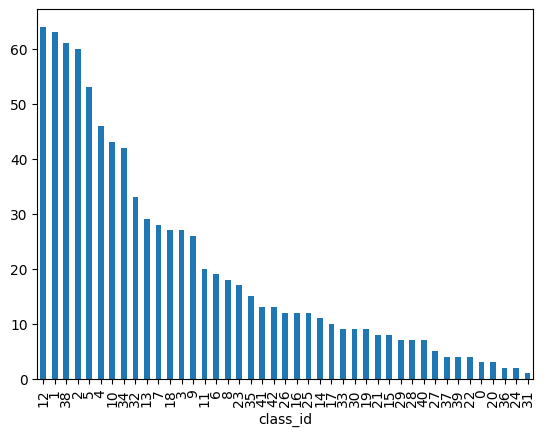

In [15]:
print("\nDistribución de Clases")
class_counts = df_gtsdb['class_id'].value_counts().sort_values(ascending=False)
print(class_counts)
class_counts.plot(kind='bar')

## Recortar imagenes con señales y guardarlas en carpetas según su tipo

In [16]:
# --- Definición de la función de conversión de coordenadas ---

def yolo_to_abs_coords(row):
    """
    Convierte las coordenadas YOLO normalizadas (centro, w, h)
    a coordenadas absolutas de píxeles (xmin, ymin, xmax, ymax).
    """
    try:
        # 1. Cargar la imagen para obtener su tamaño (Alto, Ancho)
        # Usamos cv2.IMREAD_COLOR para cargar la imagen en color
        img = cv2.imread(row['image_path'], cv2.IMREAD_COLOR)
        if img is None:
            # Si la imagen no se carga, retornamos NaN
            return [np.nan] * 4

        H, W, _ = img.shape # Alto (Height), Ancho (Width), Canales

        # 2. Extracción de coordenadas normalizadas del DataFrame
        x_center_norm = row['x_center_norm']
        y_center_norm = row['y_center_norm']
        width_norm = row['width_norm']
        height_norm = row['height_norm']

        # 3. Conversión a coordenadas absolutas (en píxeles)
        
        # Ancho y alto absoluto
        w_abs = width_norm * W
        h_abs = height_norm * H

        # Centro absoluto
        x_center_abs = x_center_norm * W
        y_center_abs = y_center_norm * H

        # Coordenadas de la esquina superior izquierda (Min)
        x_min = int(x_center_abs - (w_abs / 2))
        y_min = int(y_center_abs - (h_abs / 2))

        # Coordenadas de la esquina inferior derecha (Max)
        x_max = int(x_center_abs + (w_abs / 2))
        y_max = int(y_center_abs + (h_abs / 2))

        # 4. Asegurarse de que las coordenadas estén dentro de los límites de la imagen [0, W] y [0, H]
        x_min = max(0, x_min)
        y_min = max(0, y_min)
        x_max = min(W, x_max)
        y_max = min(H, y_max)
        
        # Devolvemos las coordenadas absolutas
        return [x_min, y_min, x_max, y_max]

    except Exception as e:
        print(f"Error procesando {row['image_path']}: {e}")
        return [np.nan] * 4


# --- Aplicación de la función al DataFrame ---

# Aplicamos la función y expandimos la lista retornada en cuatro nuevas columnas
df_gtsdb[['x_min', 'y_min', 'x_max', 'y_max']] = df_gtsdb.apply(
    yolo_to_abs_coords, axis=1, result_type='expand'
)

# Eliminamos filas donde la carga de la imagen falló
df_gtsdb.dropna(subset=['x_min'], inplace=True)
df_gtsdb[['x_min', 'y_min', 'x_max', 'y_max']] = df_gtsdb[['x_min', 'y_min', 'x_max', 'y_max']].astype(int)

print("DataFrame con coordenadas absolutas:")
print(df_gtsdb[['image_path', 'x_min', 'y_min', 'x_max', 'y_max']].head())

DataFrame con coordenadas absolutas:
                                          image_path  x_min  y_min  x_max  \
0  /content/gtsdb_data/GTSDB_Train_and_Test/Train...    456    559    477   
1  /content/gtsdb_data/GTSDB_Train_and_Test/Train...   1210    533   1249   
2  /content/gtsdb_data/GTSDB_Train_and_Test/Train...    944    435   1005   
3  /content/gtsdb_data/GTSDB_Train_and_Test/Train...   1131    479   1209   
4  /content/gtsdb_data/GTSDB_Train_and_Test/Train...   1096    210   1184   

   y_max  
0    581  
1    572  
2    492  
3    549  
4    287  


In [17]:
# --- Constantes para la salida ---
OUTPUT_SIZE = (64, 64) # Tamaño fijo de 64x64 píxeles
OUTPUT_DIR = 'gtsdb_cropped_signals'

# Crear el directorio de salida si no existe
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- Definición de la función de recorte y guardado ---

def crop_and_save_signal(row, output_dir, size):
    """
    Carga la imagen, recorta la señal según las coordenadas absolutas,
    la redimensiona y la guarda en una carpeta.
    """
    try:
        # Cargar la imagen
        img = cv2.imread(row['image_path'])
        
        if img is None:
            return False

        # Extraer coordenadas absolutas (ya convertidas y limitadas)
        x_min, y_min, x_max, y_max = row['x_min'], row['y_min'], row['x_max'], row['y_max']

        # 1. Recorte (Cropping)
        # La indexación de OpenCV/Numpy es [y_min:y_max, x_min:x_max]
        cropped_img = img[y_min:y_max, x_min:x_max]
        
        # Pequeña "Maña" de la Experiencia: A veces el bounding box es de 0x0
        if cropped_img.size == 0:
            # print(f"Advertencia: Caja delimitadora vacía para {row['image_id']}")
            return False

        # 2. Redimensionamiento (Resizing)
        # Usamos cv2.INTER_AREA para reducir el tamaño (es bueno para evitar aliasing)
        resized_img = cv2.resize(cropped_img, size, interpolation=cv2.INTER_AREA)

        # 3. Guardar la imagen preprocesada
        # Creamos un nombre único para la señal (ImagenID_ClaseID_ÍndiceFila)
        output_filename = f"{row['image_id']}_{row['class_id']}_{row.name}.png"
        output_path = os.path.join(output_dir, output_filename)
        
        cv2.imwrite(output_path, resized_img)
        
        return output_path

    except Exception as e:
        print(f"Error en recorte/guardado de {row['image_path']}: {e}")
        return False

# --- Ejecución del proceso en el DataFrame ---
print("\nIniciando proceso de recorte, redimensionamiento y guardado...")

# Aplicamos la función a cada fila y guardamos la nueva ruta
df_gtsdb['cropped_path'] = df_gtsdb.apply(
    crop_and_save_signal, 
    axis=1, 
    output_dir=OUTPUT_DIR, 
    size=OUTPUT_SIZE
)

print(f"\nProceso finalizado. {df_gtsdb['cropped_path'].count()} señales recortadas y guardadas en la carpeta '{OUTPUT_DIR}'")


Iniciando proceso de recorte, redimensionamiento y guardado...

Proceso finalizado. 866 señales recortadas y guardadas en la carpeta 'gtsdb_cropped_signals'


## Cargar Recortes de Imagenes en Memoria y Preparar los Datos (X, Y)

### Cargar Recortes

In [22]:
# Lista para almacenar las matrices de imágenes
X_list = []
# Lista para almacenar los IDs de clase (etiquetas)
Y_list = []

print("Cargando y preprocesando las imágenes recortadas...")

# Iterar sobre las filas del DataFrame
for index, row in df_gtsdb.iterrows():
    try:
        image_path = row['cropped_path']
        
        # Cargar la imagen usando OpenCV (cv2.IMREAD_COLOR para 3 canales)
        # OpenCV carga las imágenes en formato BGR por defecto
        img = cv2.imread(image_path, cv2.IMREAD_COLOR)

        if img is not None:
            # 1. Normalización de Píxeles (Escalado de 0-255 a 0-1) 
            img_normalized = img.astype(np.float32) / 255.0
            
            X_list.append(img_normalized)
            Y_list.append(row['class_id'])

    except Exception as e:
        print(f"Error al cargar la imagen {image_path}: {e}")

# Convertir las listas a arrays de NumPy
X = np.array(X_list)
Y = np.array(Y_list)

print("--- Datos de Entrada (X) Listos ---")
print(f"Forma del tensor X (Muestras, Alto, Ancho, Canales): {X.shape}")
print(f"Tipo de datos de X: {X.dtype}") 

Cargando y preprocesando las imágenes recortadas...
--- Datos de Entrada (X) Listos ---
Forma del tensor X (Muestras, Alto, Ancho, Canales): (866, 64, 64, 3)
Tipo de datos de X: float32


### Codificación de Etiquetas (Y)

In [23]:
# --- 1. Preparar el nuevo array Y (Tipo de Señal) ---
Y_type = df_gtsdb['type_of_sign'].values

# 2. Reindexar las clases de TIPO
# Crear un mapeo secuencial (0, 1, 2, ...) de los tipos de señal
unique_types = np.unique(Y_type)
type_to_index = {type_name: i for i, type_name in enumerate(unique_types)}
index_to_type = {i: type_name for type_name, i in type_to_index.items()}

# Crear el nuevo array Y reindexado
Y_type_reindexed = np.array([type_to_index[t] for t in Y_type])
NUM_CLASSES_TYPE = len(unique_types)

# 3. Codificación One-Hot
Y_type_one_hot = tf.keras.utils.to_categorical(Y_type_reindexed, num_classes=NUM_CLASSES_TYPE)

print("\n--- Nuevos Datos de Salida (Y) Listos para Clasificación de TIPO ---")
print(f"Tipos Únicos Encontrados: {unique_types}")
print(f"Forma del tensor Y_type_one_hot: {Y_type_one_hot.shape}")


--- Nuevos Datos de Salida (Y) Listos para Clasificación de TIPO ---
Tipos Únicos Encontrados: ['Fin de Restricción' 'Obligatoria' 'Peligro' 'Prioridad / Stop'
 'Prohibición']
Forma del tensor Y_type_one_hot: (866, 5)


### Configuración de Constantes

In [24]:
# Definimos una semilla global
GLOBAL_RANDOM_SEED = 42

# Definimos las proporciones
TEST_SIZE = 0.15
VALIDATION_SIZE = 0.15

def set_all_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
set_all_seeds(GLOBAL_RANDOM_SEED)

### División del Dataset (Train, Validation, Test)

In [25]:
# 1. Separar Prueba (Test)
X_train_val, X_test, Y_train_val, Y_test = train_test_split(
    X, Y_type_one_hot, 
    test_size=TEST_SIZE, 
    random_state=GLOBAL_RANDOM_SEED, 
    stratify=Y_type_reindexed # Estratificación crucial
)

# 2. Separar Entrenamiento (Train) y Validación (Validation)
# Calculamos la proporción de validación respecto al conjunto restante (15% de 85% ~ 17.65%)
val_ratio = VALIDATION_SIZE / (1.0 - TEST_SIZE)

X_train, X_val, Y_train, Y_val = train_test_split(
    X_train_val, Y_train_val, 
    test_size=val_ratio, 
    random_state=GLOBAL_RANDOM_SEED,
    # Estratificación basada en el conjunto Y_train_val (que ya es one-hot)
    # Convertimos de one-hot a índices para la estratificación
    stratify=np.argmax(Y_train_val, axis=1) 
)

print("\n--- Distribución Final de Datasets ---")
print(f"Entrenamiento (X_train, Y_train): {X_train.shape[0]} muestras")
print(f"Validación (X_val, Y_val): {X_val.shape[0]} muestras")
print(f"Prueba (X_test, Y_test): {X_test.shape[0]} muestras")
print(f"Forma final de X: {X_train.shape} (Entrada a la CNN)")
print(f"Forma final de Y: {Y_train.shape} (Salida a la CNN)")


--- Distribución Final de Datasets ---
Entrenamiento (X_train, Y_train): 606 muestras
Validación (X_val, Y_val): 130 muestras
Prueba (X_test, Y_test): 130 muestras
Forma final de X: (606, 64, 64, 3) (Entrada a la CNN)
Forma final de Y: (606, 5) (Salida a la CNN)


## Entrenamiento del Modelo CNN

### Arquitectura de la CNN

In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchsummary 


class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        
        # --- 1. Capas Convolucionales y de Agrupamiento ---
        # 1.1 Primera Capa Conv
        # Entrada: 3 canales (RGB), Salida: 32 feature maps, Kernel: 3x3
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        # Capa de Max Pooling: reduce el tamaño espacial a la mitad
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # 1.2 Segunda Capa Conv
        # Entrada: 32 feature maps, Salida: 64 feature maps, Kernel: 3x3
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        
        # 1.3 Tercera Capa Conv (Opcional, para mayor profundidad)
        # Entrada: 64 feature maps, Salida: 128 feature maps, Kernel: 3x3
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        
        # --- 2. Capas Densely Connected (Clasificador) ---
        # Calculamos el tamaño de la entrada: 
        # (Entrada 64x64) -> Pool 1 (32x32) -> Pool 2 (16x16) -> Pool 3 (8x8)
        # 8*8 * 128 feature maps = 8192 nodos
        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        
        # Dropout: Regularización para prevenir el overfitting
        self.dropout = nn.Dropout(p=0.5) 
        
        # Capa de Salida: 512 nodos -> num_classes (5)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # 1. Conv1 -> ReLU -> Pool
        x = self.pool(F.relu(self.conv1(x)))
        # 2. Conv2 -> ReLU -> Pool
        x = self.pool(F.relu(self.conv2(x)))
        # 3. Conv3 -> ReLU -> Pool
        x = self.pool(F.relu(self.conv3(x))) 
        
        # 4. Aplanamiento (Flatten)
        # La vista es (tamaño_lote, número_de_nodos)
        x = x.view(-1, 128 * 8 * 8)
        
        # 5. Capas Densely Connected
        x = F.relu(self.fc1(x))
        x = self.dropout(x) # Aplicamos dropout
        
        # 6. Salida (Logits)
        x = self.fc2(x)
        
        return x

# Detectamos el dispositivo y movemos el modelo ANTES del resumen
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(NUM_CLASSES_TYPE).to(device)

print(model)
torchsummary.summary(model, input_size=(3, 64, 64))

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=8192, out_features=512, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=512, out_features=5, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             896
         MaxPool2d-2           [-1, 32, 32, 32]               0
            Conv2d-3           [-1, 64, 32, 32]          18,496
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5          [-1, 128, 16, 16]          73,856
         MaxPool2d-6            [-1, 128, 8, 8]         

### Hiperparámetros de Entrenamiento

In [65]:
BATCH_SIZE = 64
LEARNING_RATE = 0.001
EPOCHS = 100

### Preparación de los Datos para PyTorch

In [66]:
from torch.utils.data import TensorDataset, DataLoader

# Los datos X y Y deben estar en el formato correcto para PyTorch:
# X (Imágenes): (Muestras, Canales, Alto, Ancho) -> PyTorch prefiere Canales primero
# Y (Etiquetas): (Muestras, Clases)

# Convertimos los arrays de numpy a tensores de PyTorch
# numpy X: (Muestras, Alto, Ancho, Canales) -> Permutamos los ejes
X_train_tensor = torch.from_numpy(X_train).permute(0, 3, 1, 2).float()
Y_train_tensor = torch.from_numpy(Y_train).float()

X_val_tensor = torch.from_numpy(X_val).permute(0, 3, 1, 2).float()
Y_val_tensor = torch.from_numpy(Y_val).float()

# Crear objetos Dataset
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, Y_val_tensor)

# Crear DataLoaders (para paginación)
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\nDatos convertidos a tensores y listos para PyTorch. Tamaño del lote (Batch Size): {BATCH_SIZE}")


Datos convertidos a tensores y listos para PyTorch. Tamaño del lote (Batch Size): 64


### Función de Pérdida y Optimizador

In [67]:
import torch.optim as optim

# Detectar si hay GPU disponible y mover el modelo allí
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Definir la función de pérdida
criterion = nn.CrossEntropyLoss()

# Definir el optimizador
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(f"Entrenando en: {device}")

Entrenando en: cuda


### Bucle de Entrenamiento (Training Loop)

In [68]:
import time

history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
best_val_loss = float('inf') # Inicializamos con valor infinito

for epoch in range(EPOCHS):
    start_time = time.time()
    
    # --- FASE DE ENTRENAMIENTO ---
    model.train() # Modo entrenamiento
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Limpiar los gradientes del paso anterior
        optimizer.zero_grad()
        
        # Forward pass: obtener predicciones
        outputs = model(inputs)
        
        # Calcular la pérdida
        # labels en CrossEntropyLoss deben ser índices (no one-hot), por eso usamos argmax
        loss = criterion(outputs, torch.argmax(labels, dim=1))
        
        # Backward pass: calcular gradientes (Backpropagation)
        loss.backward()
        
        # Actualizar pesos
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, dim=1)
        total_train += labels.size(0)
        correct_train += (predicted == torch.argmax(labels, dim=1)).sum().item()

    # --- FASE DE VALIDACIÓN ---
    model.eval() # Modo evaluación
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad(): # No necesitamos calcular gradientes en validación (ahorra memoria)
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, torch.argmax(labels, dim=1))
            
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, dim=1)
            total_val += labels.size(0)
            correct_val += (predicted == torch.argmax(labels, dim=1)).sum().item()

    # Calcular métricas finales de la época
    epoch_train_loss = train_loss / len(train_loader.dataset)
    epoch_val_loss = val_loss / len(val_loader.dataset)
    epoch_train_acc = 100 * correct_train / total_train
    epoch_val_acc = 100 * correct_val / total_val
    
    # Guardar el mejor modelo
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        torch.save(model.state_dict(), 'best_traffic_model.pth')
        print(f"Mejor modelo guardado (Val Loss: {best_val_loss:.4f}).")
    
    # Guardar en el historial
    history['train_loss'].append(epoch_train_loss)
    history['val_loss'].append(epoch_val_loss)
    history['train_acc'].append(epoch_train_acc)
    history['val_acc'].append(epoch_val_acc)
    
    duration = time.time() - start_time
    print(f"Época {epoch+1}/{EPOCHS} -> "
          f"Train Loss: {epoch_train_loss:.4f} | Acc: {epoch_train_acc:.2f}% | "
          f"Val Loss: {epoch_val_loss:.4f} | Acc: {epoch_val_acc:.2f}% | "
          f"Tiempo: {duration:.2f}s")

Mejor modelo guardado (Val Loss: 2.9746).
Época 1/100 -> Train Loss: 0.0310 | Acc: 99.01% | Val Loss: 2.9746 | Acc: 66.92% | Tiempo: 0.19s
Mejor modelo guardado (Val Loss: 2.6642).
Época 2/100 -> Train Loss: 0.0329 | Acc: 99.01% | Val Loss: 2.6642 | Acc: 63.08% | Tiempo: 0.16s
Época 3/100 -> Train Loss: 0.0183 | Acc: 99.50% | Val Loss: 2.7789 | Acc: 68.46% | Tiempo: 0.13s
Época 4/100 -> Train Loss: 0.0274 | Acc: 99.01% | Val Loss: 3.2191 | Acc: 59.23% | Tiempo: 0.12s
Época 5/100 -> Train Loss: 0.0190 | Acc: 99.50% | Val Loss: 2.9432 | Acc: 71.54% | Tiempo: 0.12s
Época 6/100 -> Train Loss: 0.0146 | Acc: 99.01% | Val Loss: 2.9493 | Acc: 64.62% | Tiempo: 0.12s
Mejor modelo guardado (Val Loss: 2.6237).
Época 7/100 -> Train Loss: 0.0172 | Acc: 99.17% | Val Loss: 2.6237 | Acc: 70.77% | Tiempo: 0.15s
Época 8/100 -> Train Loss: 0.0085 | Acc: 99.67% | Val Loss: 2.6906 | Acc: 67.69% | Tiempo: 0.12s
Época 9/100 -> Train Loss: 0.0179 | Acc: 99.01% | Val Loss: 2.8132 | Acc: 67.69% | Tiempo: 0.12s
M

### Visualización de Resultados

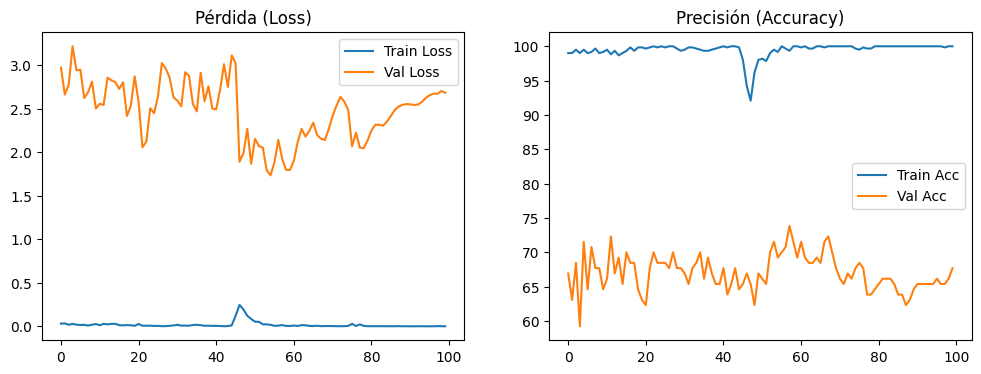

In [69]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.legend(); plt.title('Pérdida (Loss)')

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.legend(); plt.title('Precisión (Accuracy)')
plt.show()

## Evaluación con el Conjunto de Prueba (Test Set)

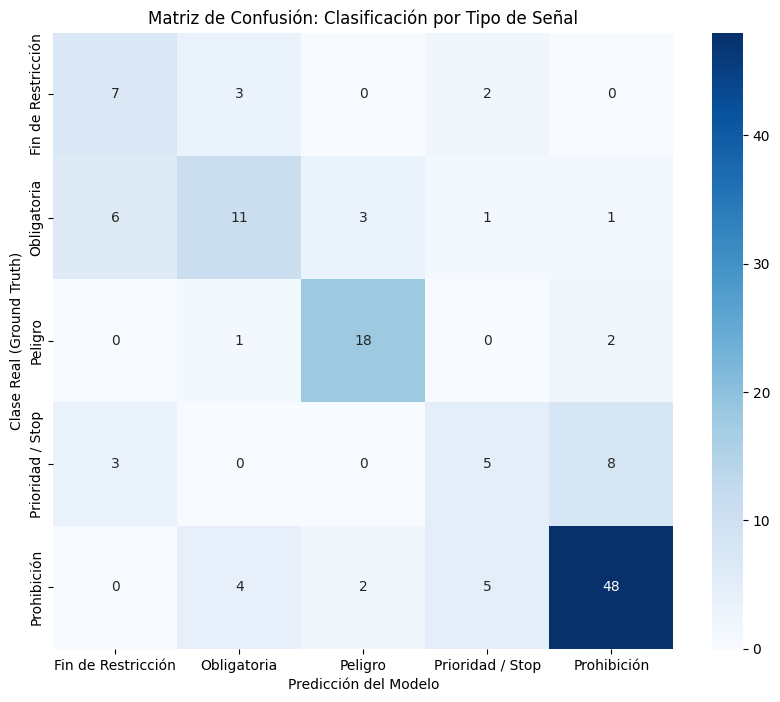

In [70]:
from sklearn.metrics import confusion_matrix

# Cargar los mejores pesos guardados durante el entrenamiento
model.load_state_dict(torch.load('best_traffic_model.pth'))
model.to(device)
model.eval()

y_true = []
y_pred = []

# Crear el test dataset y loader
X_test_tensor = torch.from_numpy(X_test).permute(0, 3, 1, 2).float()
Y_test_tensor = torch.from_numpy(Y_test).float()
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Obtener predicciones sobre el conjunto de TEST (el que nunca vio)
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        
        _, predicted = torch.max(outputs, dim=1)
        
        y_true.extend(torch.argmax(labels, dim=1).cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Calcular la matriz
cm = confusion_matrix(y_true, y_pred)

# Graficar
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=unique_types, 
            yticklabels=unique_types)
plt.xlabel('Predicción del Modelo')
plt.ylabel('Clase Real (Ground Truth)')
plt.title('Matriz de Confusión: Clasificación por Tipo de Señal')
plt.show()

In [71]:
from sklearn.metrics import classification_report

print("\n--- Informe de Clasificación Detallado ---")
print(classification_report(y_true, y_pred, target_names=unique_types))


--- Informe de Clasificación Detallado ---
                    precision    recall  f1-score   support

Fin de Restricción       0.44      0.58      0.50        12
       Obligatoria       0.58      0.50      0.54        22
           Peligro       0.78      0.86      0.82        21
  Prioridad / Stop       0.38      0.31      0.34        16
       Prohibición       0.81      0.81      0.81        59

          accuracy                           0.68       130
         macro avg       0.60      0.61      0.60       130
      weighted avg       0.68      0.68      0.68       130



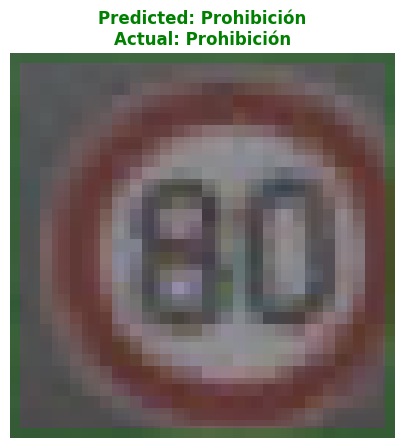

In [79]:
import random

def visual_check_random_sample(X_test, Y_test, model, device, index_to_type):
    # 1. Seleccionar un índice aleatorio del set de prueba
    idx = random.randint(0, len(X_test) - 1)
    
    # 2. Preparar la imagen para el modelo (tensor con batch dimension)
    # X_test ya es el array de numpy (N, H, W, C) que creamos antes
    sample_img_np = X_test[idx] 
    sample_tensor = torch.from_numpy(sample_img_np).permute(2, 0, 1).float().unsqueeze(0).to(device)
    
    # 3. Obtener la etiqueta real
    actual_idx = np.argmax(Y_test[idx])
    actual_label = index_to_type[actual_idx]
    
    # 4. Realizar la predicción
    model.eval()
    with torch.no_grad():
        output = model(sample_tensor)
        prediction_idx = torch.argmax(output, dim=1).item()
        predicted_label = index_to_type[prediction_idx]
        
    # 5. Visualización
    plt.figure(figsize=(5, 5))
    
    # Dibujamos un recuadro alrededor de la imagen para simular el "bounding box"
    # El color será verde si acertó, rojo si falló
    color = 'green' if predicted_label == actual_label else 'red'
    
    # Mostramos la imagen (recordar que estaba normalizada 0-1)
    # Si la cargaste con OpenCV, los canales están en BGR, hay que pasarlos a RGB para plt
    img_rgb = cv2.cvtColor((sample_img_np * 255).astype(np.uint8), cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    
    # Añadimos el recuadro estético
    ax = plt.gca()
    rect = plt.Rectangle((0, 0), 63, 63, linewidth=10, edgecolor=color, facecolor='none', alpha=0.3)
    ax.add_patch(rect)
    
    plt.title(f"Predicted: {predicted_label}\nActual: {actual_label}", 
              color=color, fontsize=12, fontweight='bold')
    plt.axis('off')
    plt.show()

# Ejecutar la función
visual_check_random_sample(X_test, Y_test, model, device, index_to_type)